# Decision Dependent Games Simulation
## Synthetic Linear Regression Problem with Location Families

We extend the linear regression example from Miller et. al. (http://arxiv.org/abs/2102.08570) to the multiplayer framework where the models of each player affect the distributions of data seen by all.

In [1]:
import numpy as np
import sys
import ipdb

sys.path.append("../")

sys.path.append("../utils/")
from utils_functions import *

from dd_game import *
from two_stage_player import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

np.random.seed(46)

The performative 2-player linear regression problem is set up as follows. For each player $k\in\{1,2\}$ we generate data

$$x^k \sim \mathcal{N}(0,\Sigma_{x^k}),\quad U^k \sim \mathcal{N}(0,\sigma_{y^k}), \quad y^k = \langle \beta^k, x^k \rangle + \langle \mu^k, \theta^k \rangle + \langle \gamma^k, \theta^{-k} \rangle + U^k$$

Where $x^k\in\mathbb{R}^d, y^k\in\mathbb{R}, U^k\in\mathbb{R}$. The performative effects are given by $\mu^k,\gamma^k$, which are drawn randomly by sampling a vector from the radius $\varepsilon^k$ spheres in $\mathbb{R}^{d_1+d_2}$ so that the distribution map for each player $k\in\{1,2\}$ is $\varepsilon^k$-sensitive.
$$\varepsilon^k = \sqrt{||\mu^k||_2^2+||\gamma^k||_2^2}$$
\
The loss function is quadratic
$$\ell((x^k,y^k);\theta^k) = \tfrac{1}{2}(y^k-{x^k}^T\theta^k)^2 = \tfrac{1}{2}||y^k||_2^2+\tfrac{1}{2}||{x^k}^T\theta^k||_2^2-y^k{x^k}^T\theta^k$$
so it is $1$-strongly convex in $\theta^k$ and $1$-smooth in $z^k$  
\
We showed that if $\ell^k(z^k,\theta^k)$ is $\eta^k$-strongly convex in $\theta^k$, is $\beta^k$-smooth in $z^k$, and the distribution map is $\varepsilon^k$-sensitive, then the game is convex, and $PR^k(\theta^k)$ for each player $k\in\{1,2\}$ is $\lambda^k$-weakly convex where $$\lambda^k=2\beta^k\varepsilon^k-\eta^k$$
If the performative risks are both strongly convex, then the game is diagonally strictly convex, so the game will have a unique Nash equilibrium, so we can enforce DSC by choosing parameters such that
$$2\beta^k\varepsilon^k\leq\eta^k$$
That is,
$$\varepsilon^k\leq\frac{1}{2} \iff DSC$$

# Configurations

In [2]:
d_1 = 2  # Dimension of each player's data/strategy
d_2 = 2

epsilon_1 = 1  # Epsilon sensitivity parameters
epsilon_2 = 1

Sigma_x_p1 = np.eye(d_1)  # Covariance of x^k
Sigma_x_p2 = np.eye(d_2)

sigma_y_p1 = 0.01  # Variance of y^k
sigma_y_p2 = 0.01

beta_p1 = np.random.normal(size=d_1)  # Linear parameter vector
beta_p2 = np.random.normal(size=d_2)

s_1 = sample_sphere(epsilon_1,d_1+d_2)  # Performativity parameters
mu_p1 = s_1[0:d_1]
gamma_p1 = s_1[d_1:]
s_2 = sample_sphere(epsilon_2,d_1+d_2)
mu_p2 = s_2[0:d_2]
gamma_p2 = s_2[d_2:]

In [3]:
p1_data_params = (Sigma_x_p1, sigma_y_p1, beta_p1, mu_p1, gamma_p1)
p1_data_generating_func = sample_from_location_family

p2_data_params = (Sigma_x_p2, sigma_y_p2, beta_p2, mu_p2, gamma_p2)
p2_data_generating_func = sample_from_location_family

In [4]:
num_rounds_lst = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000]
num_alternate_rounds = 50
num_test = 10000

# Run Game

In [5]:
p1_risks = []
p2_risks = []
theta_final_p1 = []
theta_final_p2 = []

for num_rounds in num_rounds_lst:
    player_two = TwoStagePlayer()
    player_one = TwoStagePlayer()
    game = DecisionDependentGame(player_one, player_two,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_rounds, num_alternate_rounds, num_test)
    
    game.run_train()
    game.run_post_train_alternating()
    
    p1_risks.append(game.evaluate_test_perf_risk_p1())
    p2_risks.append(game.evaluate_test_perf_risk_p2())
    
    theta_final_p1.append(game.theta_p1)
    theta_final_p2.append(game.theta_p2)
    
    #Change this flag if one wants to change print settings
    if False:
        print("---------------------")
        print("Player 1: Actual mu, gamma")
        print(mu_p1, gamma_p1)
        print("Player 1: Estimated mu, gamma")
        print(player_one.mu_hat, player_one.gamma_hat)

        print("Player 2: Actual mu, gamma")
        print(mu_p2, gamma_p2)
        print("Player 2: Estimated mu, gamma")
        print(player_two.mu_hat, player_two.gamma_hat)
        print("---------------------")

Stage 1 finished. Performing estimation now
Stage 1 finished. Performing estimation now
Stage 2 finished. Finding qs now.
Stage 2 finished. Finding qs now.
Stage 1 finished. Performing estimation now
Stage 1 finished. Performing estimation now
Stage 2 finished. Finding qs now.
Stage 2 finished. Finding qs now.
Stage 1 finished. Performing estimation now
Stage 1 finished. Performing estimation now
Stage 2 finished. Finding qs now.
Stage 2 finished. Finding qs now.
Stage 1 finished. Performing estimation now
Stage 1 finished. Performing estimation now
Stage 2 finished. Finding qs now.
Stage 2 finished. Finding qs now.
Stage 1 finished. Performing estimation now
Stage 1 finished. Performing estimation now
Stage 2 finished. Finding qs now.
Stage 2 finished. Finding qs now.
Stage 1 finished. Performing estimation now
Stage 1 finished. Performing estimation now
Stage 2 finished. Finding qs now.
Stage 2 finished. Finding qs now.
Stage 1 finished. Performing estimation now
Stage 1 finished. Pe

In [6]:
theta_PO_1, theta_PO_2 = game.solve_nash()
theta_SO_1, theta_SO_2 = game.solve_social_opt()
theta_final_p1 = np.array(theta_final_p1)
theta_final_p2 = np.array(theta_final_p2)

In [7]:
if False:
    print(mu_p1, gamma_p1)
    print(player_one.mu_hat.round(2), player_one.gamma_hat.round(2))

    print(mu_p2, gamma_p2)
    print(player_two.mu_hat.round(2), player_two.gamma_hat.round(2))

    print(game.solve_nash())
    print(game.solve_social_opt())
    
    print(game.evaluate_test_perf_risk_p1().round(3))
    print(game.evaluate_test_perf_risk_p2().round(3))

## Checking stage 1

In [8]:
print(player_one.mu_hat, player_one.gamma_hat)
print(player_two.mu_hat, player_two.gamma_hat)

[ 0.06030431 -0.02598228] [-0.0074738  -0.07471629]
[-0.00787621  0.07121843] [-0.07233956  0.00230901]


In [9]:
print(mu_p1, gamma_p1)
print(mu_p2, gamma_p2)

[ 0.05680648 -0.0242853 ] [-0.01008763 -0.07798389]
[-0.00766366  0.07029416] [-0.07069776  0.00135136]


## Evaluate the performative risks before and after Stage 3

In [10]:
PR_1, PR_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 PR = {PR_1.round(3)}\tPlayer 2 PR = {PR_2.round(3)}')

Player 1 PR = 0.007	Player 2 PR = 0.01


In [11]:
print(player_one.theta_history[-1])
print(player_two.theta_history[-1])

[0.58123599 1.23261334]
[ 0.82094615 -0.79180287]


In [12]:
game.theta_p1, game.theta_p2 = game.solve_nash()
PO_1, PO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 PO = {PO_1.round(3)}\tPlayer 2 PO = {PO_2.round(3)}')

Player 1 PO = 0.007	Player 2 PO = 0.01


In [13]:
game.theta_p1, game.theta_p2 = game.solve_social_opt()
SO_1, SO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 SO = {SO_1.round(3)}\tPlayer 2 SO = {SO_2.round(3)}')

Player 1 SO = 0.007	Player 2 SO = 0.01


## Plots

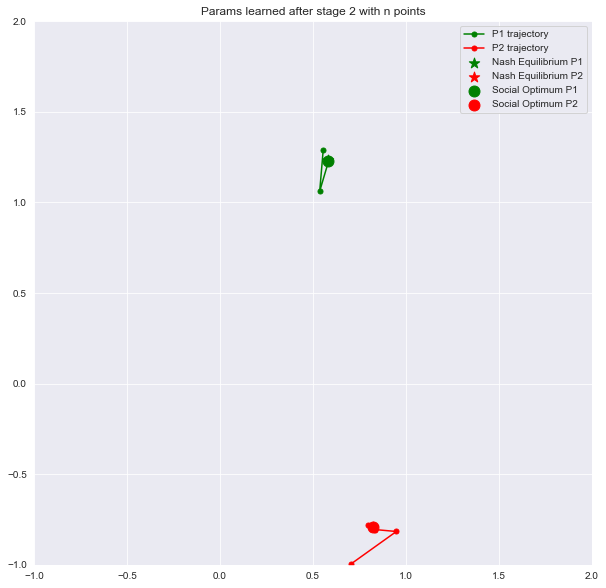

In [14]:
plt.figure(figsize=(10,10))
x_nash_p1 = [theta_PO_1[0]]
y_nash_p1 = [theta_PO_1[1]]
plt.scatter(x_nash_p1, y_nash_p1,
            label='Nash Equilibrium P1', marker='*', color='g', s=120)

x_nash_p2 = theta_PO_2[0]
y_nash_p2 = theta_PO_2[1]
plt.scatter(x_nash_p2,y_nash_p2,
            label='Nash Equilibrium P2', marker='*', color='r', s=120)

x_so_p1 = [theta_SO_1[0]]
y_so_p1 = [theta_SO_1[1]]
plt.scatter(x_so_p1, y_so_p1,
            label='Social Optimum P1', marker='o', color='g', s=120)

x_so_p2 = theta_SO_2[0]
y_so_p2 = theta_SO_2[1]
plt.scatter(x_so_p2,y_so_p2,
            label='Social Optimum P2', marker='o', color='r', s=120)

x2 = theta_final_p1[:, 0]
y2 = theta_final_p1[:, 1]
plt.plot(x2[1:],y2[1:],
         label='P1 trajectory', marker='o', color='g', markersize=5)

x3 = theta_final_p2[:, 0]
y3 = theta_final_p2[:, 1]
plt.plot(x3[1:],y3[1:],
         label='P2 trajectory', marker='o', color='r', markersize=5)

plt.legend()
plt.ylim(-1,2)
plt.xlim(-1,2)
plt.title("Params learned after stage 2 with n points")
plt.show()

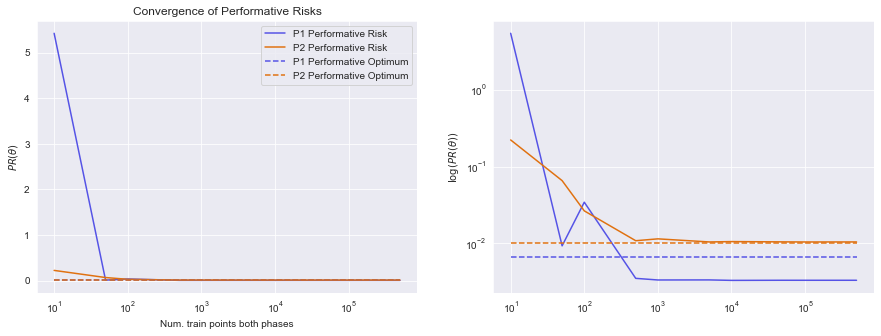

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(num_rounds_lst, p1_risks,
         color='#5553E6', label='P1 Performative Risk')
plt.semilogx(num_rounds_lst, p2_risks,
         color='#E07110', label='P2 Performative Risk')
plt.semilogx(num_rounds_lst, [PO_1 for i in num_rounds_lst],
         '--', color='#5553E6', label='P1 Performative Optimum')
plt.semilogx(num_rounds_lst, [PO_2 for i in num_rounds_lst],
         '--', color='#E07110', label='P2 Performative Optimum')
plt.xlabel("Num. train points both phases")
plt.ylabel(r"$PR(\theta)$")
plt.title("Convergence of Performative Risks")
plt.legend()

plt.subplot(1,2,2)
plt.loglog(num_rounds_lst, p1_risks,
         color='#5553E6', label='P1 Performative Risk')
plt.loglog(num_rounds_lst, p2_risks,
         color='#E07110', label='P2 Performative Risk')
plt.loglog(num_rounds_lst, [PO_1 for i in num_rounds_lst],
         '--', color='#5553E6', label='P1 Performative Optimum')
plt.loglog(num_rounds_lst, [PO_2 for i in num_rounds_lst],
         '--', color='#E07110', label='P2 Performative Optimum')
plt.ylabel(r"$\log(PR(\theta))$")
plt.show()

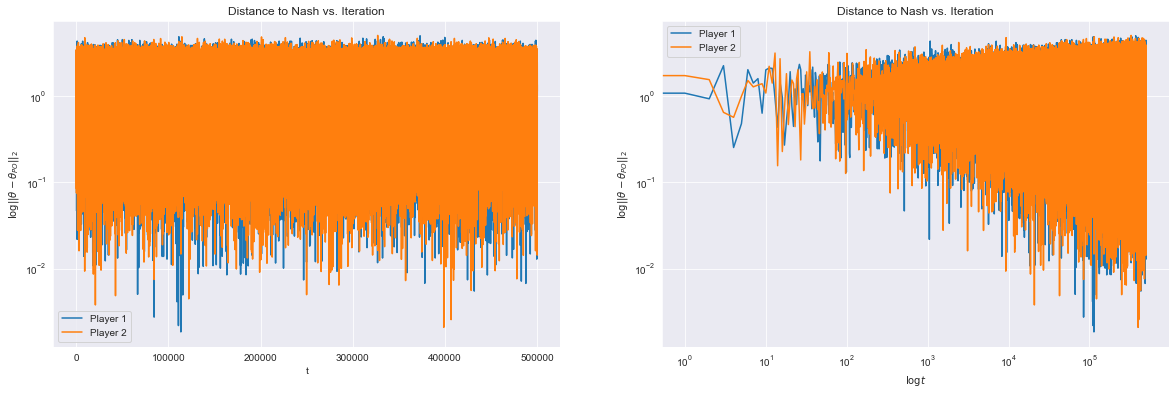

In [16]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.semilogy([t for t in range(len(player_one.theta_history))],np.linalg.norm(PO_1-np.array(player_one.theta_history),axis=1),label='Player 1')
plt.semilogy([t for t in range(len(player_two.theta_history))],np.linalg.norm(PO_2-np.array(player_two.theta_history),axis=1),label='Player 2')
plt.title("Distance to Nash vs. Iteration")
plt.ylabel(r"$\log||\theta - \theta_{PO}||_2$")
plt.xlabel(r"t")
plt.legend()
plt.subplot(1,2,2)
plt.loglog([t for t in range(len(player_one.theta_history))],np.linalg.norm(PO_1-np.array(player_one.theta_history),axis=1),label='Player 1')
plt.loglog([t for t in range(len(player_two.theta_history))],np.linalg.norm(PO_2-np.array(player_two.theta_history),axis=1),label='Player 2')
plt.title("Distance to Nash vs. Iteration")
plt.ylabel(r"$\log||\theta - \theta_{PO}||_2$")
plt.xlabel(r"$\log t$")
plt.legend()
plt.show()

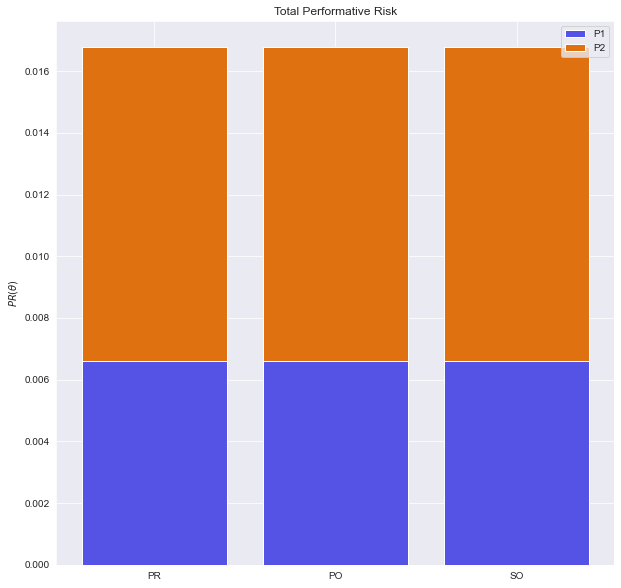

In [17]:
plt.figure(figsize=(10,10))
labels = ['PR', 'PO', 'SO']
plt.bar((1,2,3), (PR_1,PO_1,SO_1), label='P1', tick_label=labels, color='#5553E6')
plt.bar((1,2,3), (PR_2,PO_2,SO_2), bottom=(PR_1,PO_1,SO_1), label='P2', color='#E07110')
plt.title('Total Performative Risk')
plt.ylabel(r'$PR(\theta)$')
plt.legend()
plt.show()